# Load package

In [1]:
import pandas as pd     # pandas==1.0.5
import numpy as np      # numpy==1.19.2
import datetime
import sqlite3
import matplotlib.pyplot as plt     # matplotlib==3.3.2
%matplotlib inline 
from random import sample
# for plotting the map of NYC
import geopandas as gpd       # geopandas==0.6.1
from shapely import wkt       # shapely==1.6.4.post1
from shapely.geometry import Point, Polygon
# !pip install descartes

# Load data
## Load data from database

In [27]:
path = '../data/'
conn = sqlite3.connect(path + 'trip_data.db')

In [20]:
# q_drop="""DROP TABLE IF EXISTS `../data/trip_cleaned`;"""
# conn.execute( q_drop )

In [29]:
# mycur = conn.cursor() 
# mycur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
# available_table=(mycur.fetchall())
# available_table

[('fare',), ('trip',)]

In [3]:
# find the pickup and dropoff time of next trip
q_trip = """
SELECT *, 
        lag(pickup_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as pickup_datetime_next,
        lag(dropoff_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as dropoff_datetime_next
    FROM trip
ORDER BY hack_license ASC, pickup_datetime ASC, dropoff_datetime ASC
"""
sampled_trip = pd.read_sql(q_trip, conn)

In [13]:
q_fare = """
SELECT * FROM fare
"""
trip_fare = pd.read_sql(q_fare, conn)

In [25]:
conn.close()

In [8]:
# convert time columns from string to datetime
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])

In [9]:
trip_fare.loc[:,'pickup_datetime'] = pd.to_datetime(trip_fare['pickup_datetime'])
trip_fare.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013009441,2013013593,VTS,2013-06-01,CSH,5.0,0.5,0.5,0.0,0.0,6.0
1,2013012081,2013019632,VTS,2013-06-01,CRD,14.5,0.5,0.5,1.5,0.0,17.0
2,2013006133,2013029678,VTS,2013-06-01,CSH,9.5,0.5,0.5,0.0,0.0,10.5
3,2013007864,2013007860,VTS,2013-06-01,CRD,8.0,0.5,0.5,1.7,0.0,10.7
4,2013010123,2013010123,VTS,2013-06-01,CSH,19.5,0.5,0.5,0.0,0.0,20.5


In [10]:
sampled_trip = sampled_trip.merge(trip_fare.drop(['vendor_id'], axis=1), on =['medallion','hack_license','pickup_datetime'])
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_taxizone_id,pickup_datetime_next,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,360,0.97,-73.992531,...,79.0,2013-06-24 19:12:00,2013-06-24 19:30:00,CSH,6.0,1.0,0.5,0.0,0.0,7.5
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,1080,3.04,-73.982498,...,143.0,2013-06-24 19:45:00,2013-06-24 20:10:00,CRD,14.5,1.0,0.5,0.0,0.0,16.0
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,1500,4.17,-73.981850,...,79.0,2013-06-24 20:17:00,2013-06-24 20:28:00,CRD,17.5,1.0,0.5,3.7,0.0,22.7
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,660,2.35,-73.988129,...,141.0,2013-06-24 20:30:00,2013-06-24 20:35:00,CRD,10.5,0.5,0.5,2.2,0.0,13.7
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,300,1.24,-73.961098,...,263.0,2013-06-24 20:37:00,2013-06-24 20:49:00,CSH,6.0,0.5,0.5,0.0,0.0,7.0


In [11]:
# save
sampled_trip.to_csv(path + 'trip.csv', index=False)
print('Saved trip.csv!')

Saved sample_trip.csv!


## Load sample data

In [2]:
path = '../data/'
sampled_trip = pd.read_csv(path + 'trip.csv')
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_taxizone_id,pickup_datetime_next,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,360,0.97,-73.992531,...,79.0,2013-06-24 19:12:00,2013-06-24 19:30:00,CSH,6.0,1.0,0.5,0.0,0.0,7.5
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,1080,3.04,-73.982498,...,143.0,2013-06-24 19:45:00,2013-06-24 20:10:00,CRD,14.5,1.0,0.5,0.0,0.0,16.0
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,1500,4.17,-73.981850,...,79.0,2013-06-24 20:17:00,2013-06-24 20:28:00,CRD,17.5,1.0,0.5,3.7,0.0,22.7
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,660,2.35,-73.988129,...,141.0,2013-06-24 20:30:00,2013-06-24 20:35:00,CRD,10.5,0.5,0.5,2.2,0.0,13.7
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,300,1.24,-73.961098,...,263.0,2013-06-24 20:37:00,2013-06-24 20:49:00,CSH,6.0,0.5,0.5,0.0,0.0,7.0


In [3]:
# convert time columns from string to datetime
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])

There is no missing data in the original dataset. The missing data in `pickup_taxizone_id` and `dropoff_taxizone_id` means the pick-up or drop-off location is outside of NYC. The missing data in `pickup_datetime_next` and `dropoff_datetime_next` means the trip is the driver's last trip in June 2013.

In [4]:
# check missing data again
missing = sampled_trip.isna().sum(axis=0)
print(missing[missing>0])
print('==============================================')
print(missing[missing>0]/sampled_trip.shape[0])

dropoff_longitude           338
dropoff_latitude            338
pickup_taxizone_id       276753
dropoff_taxizone_id      304724
pickup_datetime_next      33486
dropoff_datetime_next     33486
dtype: int64
dropoff_longitude        0.000023
dropoff_latitude         0.000023
pickup_taxizone_id       0.019238
dropoff_taxizone_id      0.021183
pickup_datetime_next     0.002328
dropoff_datetime_next    0.002328
dtype: float64


----

# EDA
## Trip time
- Over 99% trips are within 20 mins 
- Less than 1% trips are less than 1 minute or over 3 hous. For trips longer than 3 hours, the distance travelled does not need that long time. Consider they are mistake record
- Less than 1% trips have `dropoff_time` < `pickup_time` (drop-off time ealier than pick-up time)
- Half of `dropoff_time` - `pickup_time` does not euqal to `trip_time_in_secs`, but over 99% of the difference are within 30 seconds

**Cleaning**
- Calculate `trip_time` = `dropoff_time` - `pickup_time`
- Drop trips that have at least one of the following values:
    - `dropoff_time` < `pickup_time` 
    - Trips that last less than 1 minute
    - Trips that last over 3 hours

In [5]:
N = sampled_trip.shape[0]
n0 = sum((sampled_trip['dropoff_datetime'] <= sampled_trip['pickup_datetime']))
n1 = sum((sampled_trip['dropoff_datetime'] - 
          sampled_trip['pickup_datetime']).dt.total_seconds() != sampled_trip['trip_time_in_secs'])

n2 = sum(abs((sampled_trip['dropoff_datetime'] - 
              sampled_trip['pickup_datetime']).dt.total_seconds() - sampled_trip['trip_time_in_secs'])>30)

n3 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) < pd.Timedelta(minutes=1))
n4 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) > pd.Timedelta(minutes=20))
n5 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) > pd.Timedelta(minutes=180))

print('{n0} ({n0_per:.2f}%) records: drop-off time before pick-up time\n\
{n1} ({n1_per:.2f}%) records: drop-off time - pick-up time != trip_time_in_secs\n\
{n2} ({n2_per:.2f}%) records: the difference > 30s\n\
{n3} ({n3_per:.2f}%) records: trip time less than 1 minutes\n\
{n4} ({n3_per:.2f}%) records: trip time over 20 minutes\n\
{n5} ({n5_per:.2f}%) records: trip time over 180 minutes\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                                 n1 = n1, n1_per = n1/N*100,
                                                                 n2 = n2, n2_per = n2/N*100,
                                                                 n3 = n3, n3_per = n3/N*100,
                                                                 n4 = n4, n4_per = n4/N*100,
                                                                 n5 = n5, n5_per = n5/N*100))
print((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']).describe())

56083 (0.39%) records: drop-off time before pick-up time
6245242 (43.41%) records: drop-off time - pick-up time != trip_time_in_secs
142750 (0.99%) records: the difference > 30s
106251 (0.74%) records: trip time less than 1 minutes
2411117 (0.74%) records: trip time over 20 minutes
132 (0.00%) records: trip time over 180 minutes
count                     14385456
mean     0 days 00:13:02.014114185
std      0 days 01:08:52.919766530
min             -99 days +20:42:42
25%                0 days 00:06:20
50%                0 days 00:10:36
75%                0 days 00:17:00
max               11 days 00:39:57
dtype: object


In [6]:
sampled_trip.loc[:,'trip_time'] = (sampled_trip['dropoff_datetime'] - 
                                   sampled_trip['pickup_datetime']) / pd.Timedelta(minutes=1)
sampled_trip.loc[(sampled_trip['trip_time']>180), :]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,pickup_datetime_next,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_time
884050,2013001908,2013001905,CMT,1,2013-06-18 00:06:10,2013-06-18 04:18:49,1,1948,9.0,-73.973328,...,2013-06-18 15:42:12,2013-06-18 16:02:17,CRD,25.5,0.5,0.5,9.54,5.33,41.37,252.650000
1078051,2013002326,2013002323,CMT,2,2013-06-05 15:06:39,2013-06-05 23:03:41,1,44,5.4,-73.917122,...,2013-06-05 23:04:03,2013-06-05 23:28:19,CSH,52.0,0.0,0.5,0.00,0.00,52.50,477.033333
1078137,2013002326,2013002323,CMT,2,2013-06-17 17:59:44,2013-06-17 23:18:06,1,650,30.0,-73.863701,...,2013-06-18 00:09:43,2013-06-18 00:13:10,CSH,52.0,0.0,0.5,0.00,0.00,52.50,318.366667
1078169,2013002326,2013002323,CMT,3,2013-06-21 21:06:44,2013-06-22 00:35:38,1,1398,6.3,0.000000,...,2013-06-22 00:37:11,2013-06-22 00:37:25,CSH,40.0,0.5,0.0,0.00,0.00,40.50,208.900000
1078199,2013002326,2013002323,CMT,1,2013-06-24 14:57:07,2013-06-24 20:39:26,1,759,5.8,-73.894104,...,2013-06-25 11:15:39,2013-06-25 11:36:57,CSH,2.5,0.5,0.5,0.00,5.33,8.83,342.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13497974,2013005341,2013034867,CMT,1,2013-06-13 17:39:05,2013-06-24 17:51:13,1,563,0.7,-73.962631,...,2013-06-14 17:27:08,2013-06-14 17:38:01,CRD,7.0,1.0,0.5,2.12,0.00,10.62,15852.133333
13852976,2013010886,2013036116,CMT,2,2013-06-01 11:11:38,2013-06-01 14:49:26,2,5431,22.3,-73.785477,...,2013-06-02 05:34:06,2013-06-02 05:57:44,CRD,52.0,0.0,0.5,11.56,5.33,69.39,217.800000
13853031,2013010886,2013036116,CMT,5,2013-06-28 05:22:41,2013-06-28 11:59:54,1,2304,22.9,-74.000740,...,2013-06-28 12:17:03,2013-06-28 12:26:09,CRD,160.0,0.0,0.5,4.50,0.00,165.00,397.216667
14079377,2013006205,2013036907,CMT,1,2013-06-06 18:19:57,2013-06-07 17:12:49,1,1006,2.1,-74.004669,...,2013-06-07 18:23:29,2013-06-07 18:42:10,CSH,2.5,1.0,0.5,0.00,5.33,9.33,1372.866667


In [7]:
index_time = (sampled_trip['trip_time']>1) & (sampled_trip['trip_time']<=180)

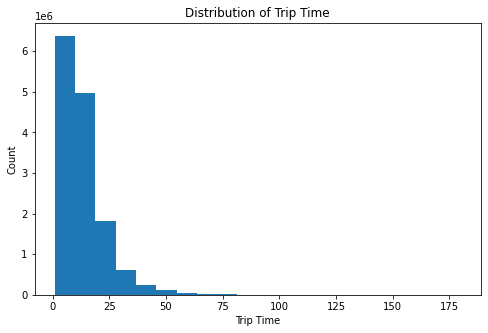

In [8]:
plt.figure(figsize=(8,5))
sampled_trip.loc[index_time, 'trip_time'].hist(bins=20, grid=False);
plt.xlabel('Trip Time');
plt.ylabel('Count');
plt.title('Distribution of Trip Time');

## Trip distance
- Over 75% trips are within 4 miles
- Less than 1% trips are longer than 30 miles
- Over 75% trips have average speed of about 15 mph

**Cleaning**
- Calculate `ave_speed` = `trip_distance` / `trip_time` * 60
- Drop trips that have at least one of the following values:
    - Speed over 50 mph ([highest speed limit in New York](https://www1.nyc.gov/html/dot/downloads/pdf/current-pre-vision-zero-speed-limit-maps.pdf))
    - Trips that longer than 30 miles ([The Manhattan Island](https://www.nycgo.com/plan-your-trip/basic-information/) is roughly 13.4 miles long and about 2.3 miles wide)

In [9]:
N = sampled_trip.shape[0]
n0 = len(sampled_trip.loc[(sampled_trip['trip_distance']<10), 'trip_distance'])
n1 = len(sampled_trip.loc[(sampled_trip['trip_distance']>30), 'trip_distance'])
n2 = len(sampled_trip.loc[(sampled_trip['trip_distance']<=0), 'trip_distance'])
print('{n0} ({n0_per:.2f}%) records: trip distance within 10 mile\n\
{n1} ({n1_per:.2f}%) records: trip distance are over 30 mile\n\
{n2} ({n2_per:.2f}%) records: trip distance <= 0 mile\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                             n1 = n1, n1_per = n1/N*100,
                                                             n2 = n2, n2_per = n2/N*100))
print(sampled_trip['trip_distance'].describe())
print('=========================================================\nAverage speed')
print((sampled_trip['trip_distance'] / sampled_trip['trip_time'] * 60).describe())

13666382 (95.00%) records: trip distance within 10 mile
3167 (0.02%) records: trip distance are over 30 mile
79039 (0.55%) records: trip distance <= 0 mile
count    1.438546e+07
mean     2.939907e+00
std      3.400868e+00
min      0.000000e+00
25%      1.080000e+00
50%      1.800000e+00
75%      3.300000e+00
max      1.000000e+02
Name: trip_distance, dtype: float64
Average speed
count    1.435719e+07
mean              inf
std               NaN
min     -4.590000e+03
25%      8.353846e+00
50%      1.155000e+01
75%      1.575000e+01
max               inf
dtype: float64


In [10]:
index_distance = (((sampled_trip['trip_distance']/sampled_trip['trip_time']*60)<50) & 
                  (sampled_trip['trip_distance']<30) & 
                  (sampled_trip['trip_distance']>0))

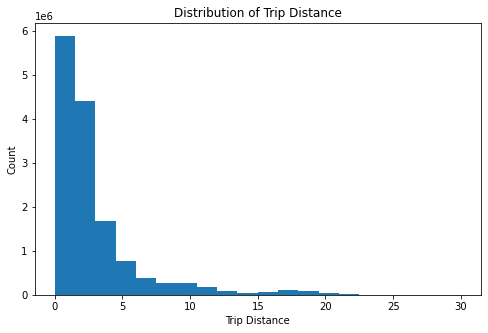

In [11]:
plt.figure(figsize=(8,5))
sampled_trip.loc[index_distance, 'trip_distance'].hist(bins=20, grid=False);
plt.xlabel('Trip Distance');
plt.ylabel('Count');
plt.title('Distribution of Trip Distance');

## Trip fare
- Over 99% trips have fare more than \\$2.5 and less than \\$150
- 82% trips have fare less then \\$20

**Cleaning**
- Drop trips that have trip fare over \\$150 (\\$2.5 * 60 miles)

In [12]:
N = sampled_trip.shape[0]
n0 = len(sampled_trip.loc[(sampled_trip['total_amount']<=2.5), 'total_amount'])
n1 = len(sampled_trip.loc[(sampled_trip['total_amount']<=20), 'total_amount'])
n2 = len(sampled_trip.loc[(sampled_trip['total_amount']<150), 'total_amount'])
print('{n0} ({n0_per:.2f}%) records: trip fare < $2.5\n\
{n1} ({n1_per:.2f}%) records: trip fare < $20\n\
{n2} ({n2_per:.2f}%) records: trip fare < $150\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                                  n1 = n1, n1_per = n1/N*100,
                                                                  n2 = n2, n2_per = n2/N*100))
print(sampled_trip['total_amount'].describe())

13 (0.00%) records: trip fare < $2.5
11861520 (82.45%) records: trip fare < $20
14382428 (99.98%) records: trip fare < $150
count    1.438546e+07
mean     1.506042e+01
std      1.228345e+01
min      2.500000e+00
25%      8.000000e+00
50%      1.140000e+01
75%      1.700000e+01
max      5.655000e+02
Name: total_amount, dtype: float64


In [13]:
index_fare = sampled_trip['total_amount']<150

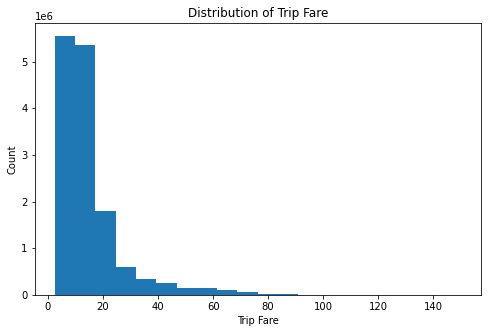

In [14]:
plt.figure(figsize=(8,5))
sampled_trip.loc[index_fare, 'total_amount'].hist(bins=20, grid=False);
plt.xlabel('Trip Fare');
plt.ylabel('Count');
plt.title('Distribution of Trip Fare');

# Pick-up and drop-off location
- Over 98% trips' pick-up and drop-off locations are within NYC

**Cleaning**
- Drop trips with pick-up or drop-off location outside of NYC

In [15]:
# download map here: https://data.cityofnewyork.us/Health/Modified-Zip-Code-Tabulation-Areas-MODZCTA-Map/5fzm-kpwv
nyc_map = pd.read_csv(path + '../data/Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv')
nyc_map['geometry'] = nyc_map['the_geom'].apply(wkt.loads)
nyc_map = gpd.GeoDataFrame(nyc_map, crs='EPSG:4326').drop('the_geom', axis=1)

# download map here: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq
# nyc_map = gpd.read_file(path + '../Neighborhood Tabulation Areas (NTA).geojson')

# download map here: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u
# nyc_map = gpd.read_file(path + '../ZIP_CODE_040114/ZIP_CODE_040114.shp')

# download map here: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
# nyc_map = gpd.read_file(path +'../Borough_Boundaries/geo_export_573e53b9-f38f-46eb-be8d-0f07d0d0e9d1.shp')
nyc_map.head()

,MODZCTA,label,ZCTA,pop_est,geometry
0,10001,"10001, 10118","10001, 10119, 10199",23072,"MULTIPOLYGON (((-73.98774 40.74407, -73.98819 ..."
1,10002,10002,10002,74993,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 ..."
2,10003,10003,10003,54682,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ..."
3,10004,10004,10004,3028,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ..."
4,10005,10005,"10005, 10271",8831,"MULTIPOLYGON (((-74.00783 40.70309, -74.00786 ..."


In [16]:
# the latitude and longtitude of nyc (roughly) 
nyc_loc = [-74.25,-73.75, 40.45, 40.95]

# drop gps records outside of nyc 
index_location = ~(sampled_trip[['dropoff_longitude','dropoff_latitude','pickup_taxizone_id','dropoff_taxizone_id']].isna().any(1))

N = sampled_trip.shape[0]
n0 = sum(index_location)
print('{n0} ({n0_per:.2f}%) are in NYC'.format(n0=n0, n0_per=n0/N*100))

14063415 (97.76%) are in NYC


In [17]:
# location_index = sampled_trip.index.tolist()
features = ['hack_license','trip_distance',
            'pickup_longitude','pickup_latitude',
            'dropoff_longitude','dropoff_latitude']

sample_n = 5000
sample_index = sample(index_location[index_location==True].index.tolist(), sample_n)

# convert the first pickup location to geometric form
pickup_location = gpd.GeoDataFrame(sampled_trip.loc[sample_index, features], 
                                   geometry = gpd.points_from_xy(sampled_trip.loc[sample_index, 'pickup_longitude'],
                                                                 sampled_trip.loc[sample_index, 'pickup_latitude']))

# convert the last dropoff location to geometric form
dropoff_location = gpd.GeoDataFrame(sampled_trip.loc[sample_index, features], 
                                    geometry = gpd.points_from_xy(sampled_trip.loc[sample_index, 'dropoff_longitude'],
                                                                  sampled_trip.loc[sample_index, 'dropoff_latitude']))

pickup_location.head()

,hack_license,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,geometry
4405502,2013009688,1.80,-74.002678,40.728619,-73.984177,40.746460,POINT (-74.00268 40.72862)
2923421,2013006338,1.80,-73.983414,40.768158,-73.975807,40.750038,POINT (-73.98341 40.76816)
6897908,2013015547,1.80,-73.990295,40.756248,-73.974541,40.744209,POINT (-73.99029 40.75625)
9044953,2013020938,10.45,-73.945435,40.721107,-73.978661,40.781712,POINT (-73.94544 40.72111)
2147702,2013004632,1.50,-73.993439,40.724506,-73.995125,40.739643,POINT (-73.99344 40.72451)


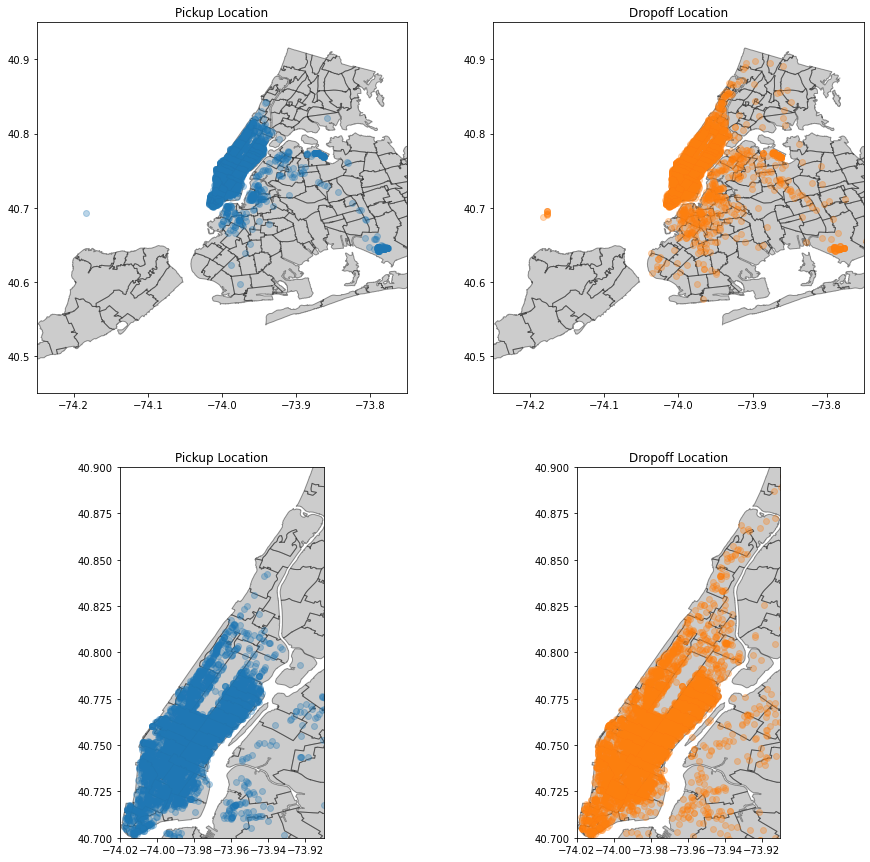

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
# add mapfile to axes
nyc_map.plot(ax=ax[0,0], alpha=0.4, edgecolor='k', color='grey');
pickup_location.plot(ax=ax[0,0], color='tab:blue', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[0,0].set_xlim(nyc_loc[0], nyc_loc[1]);
ax[0,0].set_ylim(nyc_loc[2], nyc_loc[3]);
ax[0,0].set_title('Pickup Location');

# add mapfile to axes
nyc_map.plot(ax=ax[0,1], alpha=0.4, edgecolor='k', color='grey');
dropoff_location.plot(ax=ax[0,1], color='tab:orange', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[0,1].set_xlim(nyc_loc[0], nyc_loc[1]);
ax[0,1].set_ylim(nyc_loc[2], nyc_loc[3]);
ax[0,1].set_title('Dropoff Location');

nyc_map.plot(ax=ax[1,0], alpha=0.4, edgecolor='k', color='grey');
pickup_location.plot(ax=ax[1,0], color='tab:blue', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[1,0].set_xlim(-74.02,-73.91);
ax[1,0].set_ylim( 40.7,40.9);
ax[1,0].set_title('Pickup Location');

# add mapfile to axes
nyc_map.plot(ax=ax[1,1], alpha=0.4, edgecolor='k', color='grey');
dropoff_location.plot(ax=ax[1,1], color='tab:orange', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[1,1].set_xlim(-74.02,-73.91);
ax[1,1].set_ylim( 40.7,40.9);
ax[1,1].set_title('Dropoff Location');

----
## Drop outliers

In [19]:
# drop outliers
N = sampled_trip.shape[0]
n1 = sum(~(index_time & index_distance & index_fare & index_location))
print('drop {:.2f} % of data'.format(n1/N*100))
sampled_trip = sampled_trip.loc[(index_time & index_distance & index_fare & index_location), :]\
                            .drop('trip_time_in_secs', axis=1) \
                            .sort_values(['hack_license', 'pickup_datetime', 'dropoff_datetime'])
# recalculate delta
sampled_trip.loc[:, 'pickup_datetime_next'] = sampled_trip.groupby(['hack_license'])['pickup_datetime'].shift(-1)
sampled_trip.loc[:, 'dropoff_datetime_next'] = sampled_trip.groupby(['hack_license'])['dropoff_datetime'].shift(-1)
sampled_trip.loc[:, 'delta'] = (sampled_trip['pickup_datetime_next'] - sampled_trip['dropoff_datetime']) / pd.Timedelta(hours=1)
sampled_trip.head()

drop 3.24 % of data


,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_time,delta
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,2013-06-24 19:30:00,CSH,6.0,1.0,0.5,0.0,0.0,7.5,6.0,0.183333
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,2013-06-24 20:10:00,CRD,14.5,1.0,0.5,0.0,0.0,16.0,18.0,0.250000
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,2013-06-24 20:28:00,CRD,17.5,1.0,0.5,3.7,0.0,22.7,25.0,0.116667
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,2013-06-24 20:35:00,CRD,10.5,0.5,0.5,2.2,0.0,13.7,11.0,0.033333
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,2013-06-24 20:49:00,CSH,6.0,0.5,0.5,0.0,0.0,7.0,5.0,0.033333


In [20]:
# check missing data again
missing = sampled_trip.isna().sum(axis=0)
print(missing[missing>0])
print('==============================================')
print(missing[missing>0]/sampled_trip.shape[0])

pickup_datetime_next     33233
dropoff_datetime_next    33233
delta                    33233
dtype: int64
pickup_datetime_next     0.002388
dropoff_datetime_next    0.002388
delta                    0.002388
dtype: float64


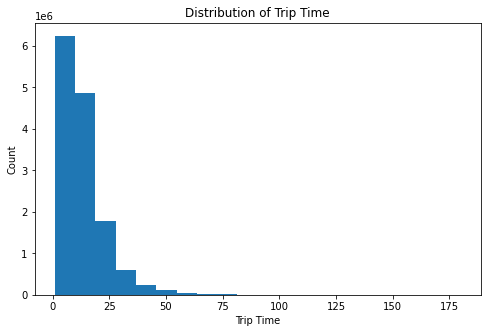

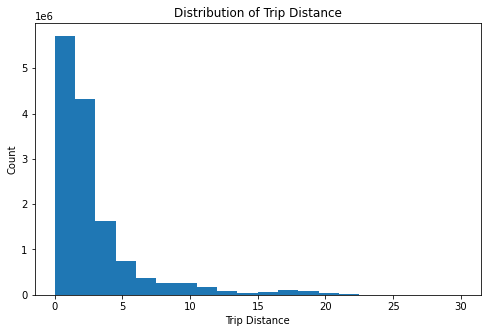

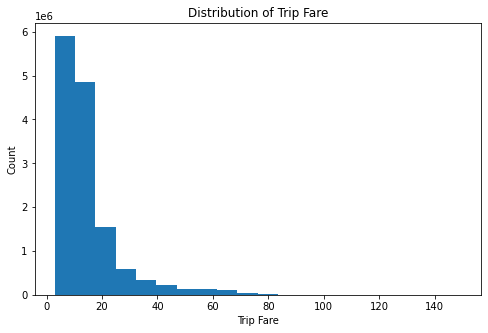

In [21]:
# replot distributions
features_plot = ['trip_time', 'trip_distance', 'total_amount']
features_title = ['Trip Time', 'Trip Distance', 'Trip Fare']
for i in range(3):
    plt.figure(figsize=(8,5))
    sampled_trip[features_plot[i]].hist(bins=20, grid=False);
    plt.xlabel('{}'.format(features_title[i]));
    plt.ylabel('Count');
    plt.title('Distribution of {}'.format(features_title[i]));

----

- k=3, 20834 (3.288%) active time < 1h, 352 (0.056%) active time > 24h.
- k=4, 11744 (1.923%) active time < 1h, 667 (0.109%) active time > 24h
- k=5, 921 (1.317%) active time < 1h, 1081 (0.180%) active time > 24h

In [42]:
k = 5

## If delta > k, the trip is the last drop off of the shift
## And the next trip of the driver is the first pickup (shifted)
sampled_trip['last_dropoff'] = [1 if d > k else 0 for d in sampled_trip['delta']]
sampled_trip['first_pickup'] = sampled_trip.groupby('hack_license')['last_dropoff'].shift(1)
sampled_trip.dropna(subset=['pickup_datetime_next', 'dropoff_datetime_next'], inplace=True) 
sampled_trip['first_pickup'].fillna(0, inplace=True)

In [43]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,trip_time,delta,last_dropoff,first_pickup,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,6.0,0.183333,0,0.0,19:00:00,19:00:00,2013-06-24,2013-06-24,1,1
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,18.0,0.250000,0,0.0,19:30:00,19:15:00,2013-06-24,2013-06-24,1,1
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,25.0,0.116667,0,0.0,20:15:00,19:45:00,2013-06-24,2013-06-24,1,1
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,11.0,0.033333,0,0.0,20:30:00,20:15:00,2013-06-24,2013-06-24,1,1
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,5.0,0.033333,0,0.0,20:30:00,20:30:00,2013-06-24,2013-06-24,1,1


In [44]:
## Extract hour and day
sampled_trip['dropoff_time'] = sampled_trip.dropoff_datetime.dt.round('15min').dt.time
sampled_trip['pickup_time'] = sampled_trip.pickup_datetime.dt.round('15min').dt.time
# sampled_trip['dropoff_time'] = sampled_trip.dropoff_datetime.dt.round('15min').dt.hour + \
#                                 sampled_trip.dropoff_datetime.dt.round('15min').dt.minute / 60
# sampled_trip['pickup_time'] = sampled_trip.pickup_datetime.dt.round('15min').dt.hour + \
#                                 sampled_trip.pickup_datetime.dt.round('15min').dt.minute / 60
sampled_trip['dropoff_day'] = sampled_trip.dropoff_datetime.dt.date
sampled_trip['pickup_day'] = sampled_trip.pickup_datetime.dt.date
sampled_trip['pickup_weekday'] = (sampled_trip.loc[:,'pickup_datetime'].dt.dayofweek // 5 == 0).astype(int)
sampled_trip['dropoff_weekday'] = (sampled_trip.loc[:,'dropoff_datetime'].dt.dayofweek // 5 == 0).astype(int)


In [45]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,trip_time,delta,last_dropoff,first_pickup,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,6.0,0.183333,0,0.0,19:00:00,19:00:00,2013-06-24,2013-06-24,1,1
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,18.0,0.250000,0,0.0,19:30:00,19:15:00,2013-06-24,2013-06-24,1,1
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,25.0,0.116667,0,0.0,20:15:00,19:45:00,2013-06-24,2013-06-24,1,1
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,11.0,0.033333,0,0.0,20:30:00,20:15:00,2013-06-24,2013-06-24,1,1
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,5.0,0.033333,0,0.0,20:30:00,20:30:00,2013-06-24,2013-06-24,1,1


## First pick-up and last drop-off distribution
- Two peaks of pick-up time: 6:00 am, 5:00 pm
- Two peaks of drop-off time: 1:00 am, 4:00 pm
- The pick-up peak on weekend morning appears later: 7:00 am
- The drop-off peak on weekend midnight appears later: 4:00 am

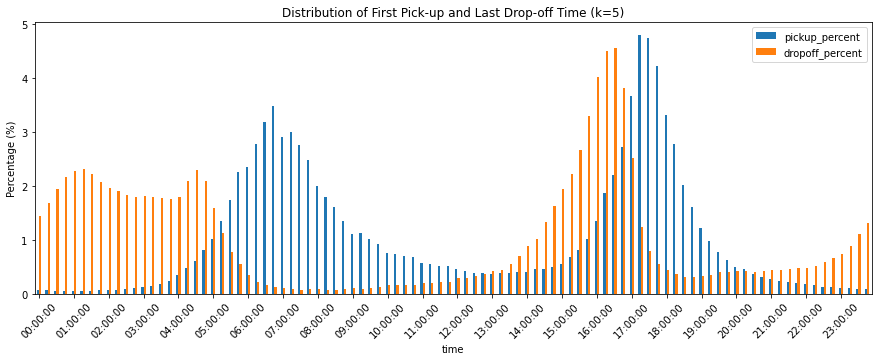

In [46]:
## Compute percentage
ticks = sorted(sampled_trip['pickup_time'].unique())

pickup_df = sampled_trip.loc[sampled_trip['first_pickup'] == 1]
pickup_per = pickup_df.groupby(['pickup_day', 'pickup_time', 'pickup_weekday'])['pickup_time'].count()
pickup_per = pd.DataFrame(pickup_per).rename(columns={'pickup_time':'pickup_percent'}).reset_index().\
                                        rename(columns={'pickup_day':'date',
                                                        'pickup_time':'time',
                                                           'pickup_weekday': 'weekday'})

dropoff_df = sampled_trip.loc[sampled_trip['last_dropoff'] == 1]
dropoff_per = dropoff_df.groupby(['dropoff_day', 'dropoff_time', 'dropoff_weekday'])['dropoff_time'].count()
# dropoff_per = dropoff_per.groupby('dropoff_day').apply(lambda x: x / x.sum() * 100)
dropoff_per = pd.DataFrame(dropoff_per).rename(columns={'dropoff_time':'dropoff_percent'}).reset_index().\
                                        rename(columns={'dropoff_day':'date',
                                                        'dropoff_time':'time',
                                                           'dropoff_weekday': 'weekday'})

pick_drop_per = pickup_per.merge(dropoff_per)
pick_drop_per.head()


# % of Pick-up and Drop-off Time
# pick_drop_per_all = pick_drop_per.groupby(['time'])['pickup_percent','dropoff_percent'].mean().\
#                                 reset_index().set_index('time')
pick_drop_per_all = pick_drop_per.groupby(['time'])[['pickup_percent','dropoff_percent']].mean()
pick_drop_per_all[['pickup_percent','dropoff_percent']] /= pick_drop_per_all[['pickup_percent','dropoff_percent']].sum() / 100

fig,ax = plt.subplots(figsize = (15,5))
pick_drop_per_all.plot(kind='bar',ax=ax);
ax.set_xlabel('time');
ax.set_ylabel('Percentage (%)');
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
ax.set_xticks(xticks[::4]);
ax.set_xticklabels(xticklabels[::4], rotation=45);
ax.set_title('Distribution of First Pick-up and Last Drop-off Time (k={})'.format(k));
ax.legend();
fig.savefig(path + '../img/pick_drop_time(k_{}).png'.format(k));

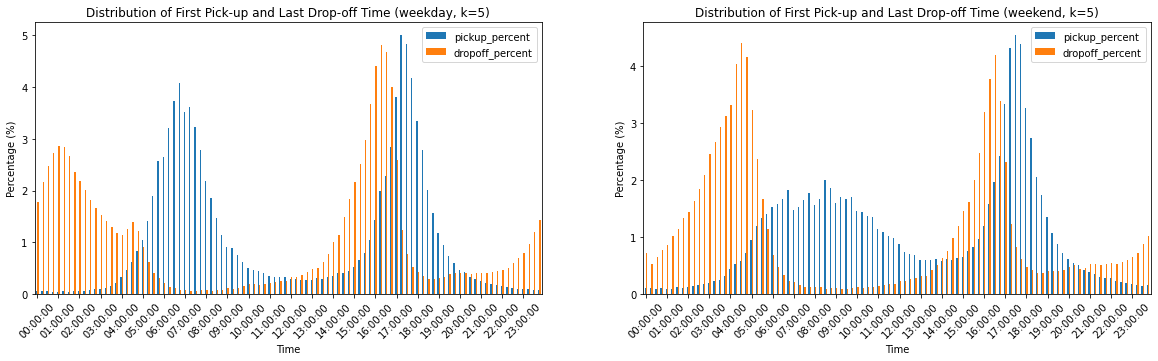

In [47]:
# Frequency of Pick-up and Drop-off Time (weekday and weekend)
# pick_drop_per_wk = pick_drop_per.groupby(['time','weekday'])['pickup_percent','dropoff_percent'].mean().\
#                                 reset_index().set_index('time')
pick_drop_per_wk = pick_drop_per.groupby(['time','weekday'])[['pickup_percent','dropoff_percent']].mean()
pick_drop_per_wk[['pickup_percent','dropoff_percent']] /= pick_drop_per_wk[['pickup_percent',
                                                                            'dropoff_percent']].groupby(level=1).sum() / 100
pick_drop_per_wk = pick_drop_per_wk.reset_index().set_index('time')

fig,ax = plt.subplots(1,2,figsize = (20,5))
pick_drop_per_wk[pick_drop_per_wk.weekday == 1].drop('weekday',axis=1).plot(kind='bar',ax=ax[0]);
pick_drop_per_wk[pick_drop_per_wk.weekday == 0].drop('weekday',axis=1).plot(kind='bar',ax=ax[1]);
xticks = ax[0].get_xticks()
xticklabels = ax[0].get_xticklabels()
ax[0].set_xticks(xticks[::4]);
ax[0].set_xticklabels(xticklabels[::4], rotation=45);
ax[0].set_xlabel('Time');
ax[0].set_ylabel('Percentage (%)');
ax[0].set_title('Distribution of First Pick-up and Last Drop-off Time (weekday, k={})'.format(k));
ax[0].legend();

xticks = ax[1].get_xticks()
xticklabels = ax[1].get_xticklabels()
ax[1].set_xticks(xticks[::4]);
ax[1].set_xticklabels(xticklabels[::4], rotation=45);
ax[1].set_xlabel('Time');
ax[1].set_ylabel('Percentage (%)');
ax[1].set_title('Distribution of First Pick-up and Last Drop-off Time (weekend, k={})'.format(k));
ax[1].legend();
fig.savefig(path + '../img/pick_drop_time_wk(k_{}).png'.format(k));

# Active time
- Over 75% shifts are within 10 hours; most of the shift are 8 to 10 hours
- Less than 1% shifts are over 24 hours.This depends on the choice of threshold `k`
- Less than 1% shifts are less than 1 hours. Some drivers would work a few trips during rest time

**Cleaning**
- Drop data that have active time less than 1 hour or over 24 hours

In [48]:
# compute active time 
# Active time = end time of the shift - start time of the shift
active_time = sampled_trip.loc[sampled_trip['last_dropoff'] == 1,
                               ['hack_license', 'dropoff_datetime','pickup_datetime_next']].\
                        rename(columns={'pickup_datetime_next':'start_datetime'}).\
                        sort_values(['hack_license','start_datetime'])

active_time['end_datetime'] = active_time.groupby(['hack_license'])['dropoff_datetime'].shift(-1)
active_time['active_hour'] = (active_time['end_datetime'] - active_time['start_datetime']) / pd.Timedelta(hours=1)
active_time = active_time.drop(['dropoff_datetime'], axis=1).dropna()
active_time.head()

,hack_license,start_datetime,end_datetime,active_hour
7,2013000001,2013-06-26 17:24:00,2013-06-27 00:44:00,7.333333
26,2013000001,2013-06-27 17:20:00,2013-06-28 01:26:00,8.100000
56,2013000001,2013-06-28 18:08:00,2013-06-29 02:58:00,8.833333
85,2013000001,2013-06-29 18:07:00,2013-06-30 04:49:00,10.700000
133,2013000002,2013-06-01 22:37:57,2013-06-02 05:40:59,7.050556


In [49]:
# drop incorrect record 
N = active_time.shape[0]
n0 = active_time[(active_time.active_hour<1)].shape[0]
n1 = active_time[(active_time.active_hour>=24)].shape[0]
print('{n0} ({n0_per:.3f}%) records: active time < 1 hour\n\
{n1} ({n1_per:.3f}%) records: active time > 24 hours\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                                  n1 = n1, n1_per = n1/N*100))
print(active_time.active_hour.describe())

7921 (1.317%) records: active time < 1 hour
1081 (0.180%) records: active time > 24 hours
count    601488.000000
mean          8.735192
std           3.188085
min           0.017222
25%           7.293333
50%           8.883333
75%          10.250000
max         207.783333
Name: active_hour, dtype: float64


In [50]:
index_active_hour = (active_time.active_hour>1) & (active_time.active_hour<24)

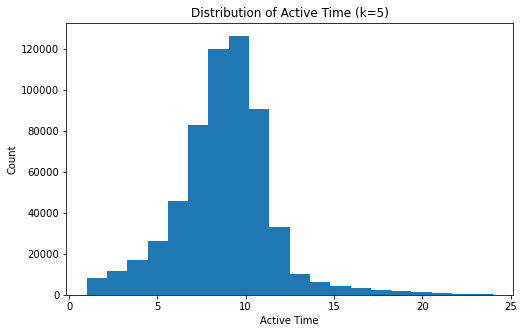

In [51]:
plt.figure(figsize=(8,5))
active_time.loc[index_active_hour, 'active_hour'].hist(bins=20, grid=False);
plt.xlabel('Active Time');
plt.ylabel('Count');
plt.title('Distribution of Active Time (k={})'.format(k));
plt.savefig(path + '../img/active_time(k_{}).png'.format(k));

## Save cleaned data

In [52]:
# save
sampled_trip.to_csv(path + 'trip_cleaned.csv', index=False)
print('Saved trip_cleaned.csv!')

Saved sampled_trip_cleaned.csv!


In [2]:
# # create database
# path = '../data/'
# sampled_trip = pd.read_csv(path + 'trip_cleaned.csv')

In [3]:
# sampled_trip.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_taxizone_id',
       'dropoff_taxizone_id', 'pickup_datetime_next', 'dropoff_datetime_next',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'trip_time', 'delta', 'last_dropoff',
       'first_pickup', 'dropoff_time', 'pickup_time', 'dropoff_day',
       'pickup_day', 'pickup_weekday', 'dropoff_weekday'],
      dtype='object')

In [5]:
# path = '../data/'
# conn = sqlite3.connect(path + 'trip_data.db')

In [6]:
# sampled_trip.to_sql('trip_cleaned', conn, index=False, if_exists='replace')

In [8]:
# conn.close()

----

# Active Time Estimation

* active time = last drop-off time - first pick-up time
* There are 2 shifts in a day. We define shift A and shift B. Early pickups are associated with later dropoffs and later pickups are associated with early dropoffs.

  ![Caption for the picture.](../fig/shift_range.png)
  
* The decision on the time ranges are based on the distributions presented above.
* There are about the same proportion of drivers in each shift.
* To simulate an active time of a driver, we
    1. randomly pick shift with 1/2 chance being in shift A (equally proportionated)
    2. randomly pick the first PU time from all PU times in the chosen shift
    3. randomly pick the last DO time from all DO times in the chosen shift (must be later than the chosen first PU time)

In [2]:
path = '../data/'
sampled_trip = pd.read_csv(path + 'trip_cleaned.csv')
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,trip_time,delta,last_dropoff,first_pickup,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,6.0,0.183333,0,0.0,19:00:00,19:00:00,2013-06-24,2013-06-24,1,1
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,18.0,0.250000,0,0.0,19:30:00,19:15:00,2013-06-24,2013-06-24,1,1
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,25.0,0.116667,0,0.0,20:15:00,19:45:00,2013-06-24,2013-06-24,1,1
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,11.0,0.033333,0,0.0,20:30:00,20:15:00,2013-06-24,2013-06-24,1,1
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,5.0,0.033333,0,0.0,20:30:00,20:30:00,2013-06-24,2013-06-24,1,1


In [12]:
# convert time columns from string to datetime
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])
sampled_trip['pickup_time'] = pd.to_datetime(sampled_trip['pickup_time'], format='%H:%M:%S').dt.time
sampled_trip['dropoff_time'] = pd.to_datetime(sampled_trip['dropoff_time'], format='%H:%M:%S').dt.time

There is a caveat in the current code. It is possible 

In [13]:
def get_shift(time, weekday=True, pickup=True):
    if weekday:
        if pickup:
            if (time > datetime.time(23, 30)) | (time <= datetime.time(11, 30)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(8, 30)) & (time <= datetime.time(20, 30)):
                return 'A'
            else:
                return 'B'            
    else: ## weekend
        if pickup:
            if (time > datetime.time(2, 0)) & (time <= datetime.time(14, 0)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(10, 0)) & (time <= datetime.time(22, 0)):
                return 'A'
            else:
                return 'B'        
        return None
    
def sample_start_end_time(first_last_trip_df, shift_prop, weekday_code):
    random_shift = np.random.choice(['A', 'B'], size=1, 
                                    p = shift_prop.loc[(shift_prop['pickup_weekday'] == weekday_code)][0].tolist())[0]
    # travel_time = datetime.timedelta(minutes=10)
#     print("random_shift: {}".format(random_shift))
    sampled_PU_time = first_last_trip_df.loc[(first_last_trip_df['_PU_shift'] == random_shift) &
                                            (first_last_trip_df['first_pickup'] == 1)]['PU_time'].sample().values[0]

    if random_shift == 'A':
        try:
            if sampled_PU_time >= datetime.time(20,30):
                sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['last_dropoff'] == 1)]['DO_time'].sample().values[0]
            else:
                sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)]['DO_time'].sample().values[0]
#         print("-", sampled_DO_time)#
        except:
            print(random_shift)
            print(sampled_PU_time)
            print(first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)].shape)
            return None, None, None
    else: #shift B dropoff
        try:
            sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                ((first_last_trip_df['DO_time'] > sampled_PU_time) |
                                                 (first_last_trip_df['DO_time'] <= datetime.time(8,30)))  &
                                                    (first_last_trip_df['last_dropoff'] == 1)]['DO_time'].sample().values[0]
        except:
            
            print(random_shift)
            print(sampled_PU_time)
            print(first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)].shape)
            return None, None
            #         print("-", sampled_DO_time) #.sample().values[0])
#     print("--Sampled PU time>> {}".format(sampled_PU_time))
#     print("--Sampled DO time>> {}".format(sampled_DO_time))
    
    return sampled_PU_time, sampled_DO_time, random_shift



In [14]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,delta,last_dropoff,first_pickup,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday,shift_id
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,0.183333,0,0.0,19:00:00,19:00:00,2013-06-24,2013-06-24,1,1,0
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,0.250000,0,0.0,19:30:00,19:15:00,2013-06-24,2013-06-24,1,1,0
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,0.116667,0,0.0,20:15:00,19:45:00,2013-06-24,2013-06-24,1,1,0
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,0.033333,0,0.0,20:30:00,20:15:00,2013-06-24,2013-06-24,1,1,0
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,0.033333,0,0.0,20:30:00,20:30:00,2013-06-24,2013-06-24,1,1,0


In [41]:
first_last_trip = sampled_trip.loc[(sampled_trip['first_pickup'] == 1) |
                                     (sampled_trip['last_dropoff'] == 1)]

first_last_trip.loc[:,'PU_time'] = first_last_trip['pickup_datetime'].apply(lambda x: x.time())
first_last_trip.loc[:,'DO_time'] = first_last_trip['dropoff_datetime'].apply(lambda x: x.time())


## determine shift for weekdays
first_last_trip.loc[(first_last_trip['pickup_weekday']==1) &
                      (first_last_trip['first_pickup']==1) , '_PU_shift'] = first_last_trip.PU_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=True))
first_last_trip.loc[(first_last_trip['dropoff_weekday']==1) &
                      (first_last_trip['last_dropoff']==1), '_DO_shift'] = first_last_trip.DO_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=False))

## determine shift for weekends
first_last_trip.loc[(first_last_trip['pickup_weekday']==0) &
                      (first_last_trip['first_pickup']==1) , '_PU_shift'] = first_last_trip.PU_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=True))
first_last_trip.loc[(first_last_trip['dropoff_weekday']==0) &
                      (first_last_trip['last_dropoff']==1), '_DO_shift'] = first_last_trip.DO_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=False))

/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

## Summary stat of actual data

## ===== 1 pickups


In [42]:
sum_stat_data = first_last_trip.loc[~first_last_trip['_PU_shift'].isna()]

sum_stat_data.rename(columns={"_PU_shift": "shift", "pickup_weekday": "weekday", 'pickup_time': 'time_minute'}, inplace=True)
sum_stat_data['time_minute_rep'] = [time.hour*60 + time.minute for time in sum_stat_data['time_minute']]#.apply(lambda x: x.time())]

## handle hours before the midnight of Shift A PU on weekday
sum_stat_data.loc[(sum_stat_data['shift'] == 'A') &
                  (sum_stat_data['weekday'] == 1), 'time_minute_rep'] = [t-(24*60) if t>(23*60+30) else t \
                                            for t in sum_stat_data.loc[(sum_stat_data['shift'] == 'A') &
                                                                       (sum_stat_data['weekday'] == 1),
                                                                       'time_minute_rep']]
## handle hours before the midnight of Shift A PU on weekday
sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                  (sum_stat_data['weekday'] == 0), 'time_minute_rep'] = [t+(24*60) if t<=(2*60) else t \
                                            for t in sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                                                                       (sum_stat_data['weekday'] == 0), 
                                                                       'time_minute_rep']]



/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [43]:
PU_mean = sum_stat_data.groupby(['weekday', 'shift'])['time_minute_rep']\
                    .agg(lambda x: "{}:{}".format(int(x.mean()//60), int(x.mean()%60)))
PU_mean.rename('Mean Start Time', inplace=True)
print('mean PU')
print(PU_mean)

PU_std = sum_stat_data.groupby(['weekday', 'shift'])['time_minute_rep']\
                    .agg(lambda x: "{}:{}".format(int(x.std()//60), int(x.std()%60)))
PU_std.rename('STD Start Time', inplace=True)
print('std PU')
print(PU_std)



mean PU
weekday  shift
0        A         8:34
         B        17:51
1        A          7:0
         B        17:16
Name: Mean Start Time, dtype: object
std PU
weekday  shift
0        A        2:33
         B        1:56
1        A        1:42
         B        1:49
Name: STD Start Time, dtype: object


## ===== 2 dropoff

In [44]:
sum_stat_data = first_last_trip.loc[~first_last_trip['_DO_shift'].isna()]

sum_stat_data.rename(columns={"_DO_shift": "shift", "pickup_weekday": "weekday", 'pickup_time': 'time_minute'}, inplace=True)
sum_stat_data['time_minute_rep'] = [time.hour*60 + time.minute for time in sum_stat_data['time_minute']]#.apply(lambda x: x.time())]

sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                         (sum_stat_data['weekday'] == 1), 'time_minute_rep'] = [t-(24*60) if t>(20*60+30) else t \
                                                                                              for t in sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                                                                                                                                 (sum_stat_data['weekday'] == 1),
                                                                                                                                 'time_minute_rep']]
                                                                                                                                 
 
                                                                                                                                 
sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                         (sum_stat_data['weekday'] == 0), 'time_minute_rep'] = [t-(24*60) if t>(22*60) else t \
                                                                                              for t in sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                                                                                                                                 (sum_stat_data['weekday'] == 0), 
                                                                                                                                 'time_minute_rep']]


DO_mean = sum_stat_data.groupby(['weekday', 'shift'])['time_minute_rep']\
                    .agg(lambda x: "{}:{}".format(int(x.mean()//60), int(x.mean()%60)))
DO_mean.rename('Mean End Time', inplace=True)
print('mean DO')
print(mean_stat)

DO_std = sum_stat_data.groupby(['weekday', 'shift'])['time_minute_rep']\
                    .agg(lambda x: "{}:{}".format(int(x.std()//60), int(x.std()%60)))
DO_std.rename('STD End Time', inplace=True)
print('std DO')
print(std_stat)



/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

mean DO
              start_time_minute end_time_minute
weekday shift                                  
0       A                  8:33           16:36
        B                 17:31             5:8
1       A                   7:2           15:41
        B                 17:14            6:24
std DO
              start_time_minute end_time_minute
weekday shift                                  
0       A                  2:32            2:21
        B                  2:45            5:21
1       A                  1:50            1:52
        B                  1:46            8:21


In [45]:
merge_stat = PU_mean.to_frame().join(DO_mean).join(PU_std).join(DO_std)
print(merge_stat)
print(merge_stat.to_latex())

              Mean Start Time Mean End Time STD Start Time STD End Time
weekday shift                                                          
0       A                8:34          16:6           2:33         2:10
        B               17:51          3:24           1:56         2:51
1       A                 7:0         15:21           1:42         1:53
        B               17:16          1:42           1:49         2:54
\begin{tabular}{llllll}
\toprule
  &   & Mean Start Time & Mean End Time & STD Start Time & STD End Time \\
weekday & shift &                 &               &                &              \\
\midrule
0 & A &            8:34 &          16:6 &           2:33 &         2:10 \\
  & B &           17:51 &          3:24 &           1:56 &         2:51 \\
1 & A &             7:0 &         15:21 &           1:42 &         1:53 \\
  & B &           17:16 &          1:42 &           1:49 &         2:54 \\
\bottomrule
\end{tabular}



## statistics summary of start and end times

In [14]:
proportion_table = first_last_trip.loc[first_last_trip['first_pickup'] == 1].groupby(['pickup_weekday', '_PU_shift']).size()\
                .groupby(['pickup_weekday']).apply(lambda x: x/x.sum()).reset_index()
proportion_table

,pickup_weekday,_PU_shift,0
0,0,A,0.505047
1,0,B,0.494953
2,1,A,0.499151
3,1,B,0.500849


## Simulate weekend active hours

In [15]:
def find_time_diff(original_do_time, original_pu_time):
    
    pu_time = datetime.datetime.combine(datetime.datetime(2020, 1,1), original_pu_time)
    if original_do_time < original_pu_time:
        do_time = datetime.datetime.combine(datetime.datetime(2020, 1,2), original_do_time)
    else:
        do_time = datetime.datetime.combine(datetime.datetime(2020, 1,1), original_do_time)
        
#     print(pu_time)
#     print(do_time)
    return (do_time - pu_time).total_seconds() / 3600
#     datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), d_list[0]) - datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), p_list[0])

In [16]:
first_last_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday,PU_time,DO_time,_PU_shift,_DO_shift
7,2013000001,2013000001,VTS,1,2013-06-24 22:07:00,2013-06-24 22:13:00,2,0.82,-73.929214,40.753971,...,22:15:00,22:00:00,2013-06-24,2013-06-24,1,1,22:07:00,22:13:00,NaN,B
8,2013000001,2013000001,VTS,1,2013-06-26 17:24:00,2013-06-26 17:35:00,1,0.86,-73.971581,40.757946,...,17:30:00,17:30:00,2013-06-26,2013-06-26,1,1,17:24:00,17:35:00,B,NaN
26,2013000001,2013000001,VTS,1,2013-06-27 00:25:00,2013-06-27 00:44:00,1,4.79,-73.980392,40.721916,...,00:45:00,00:30:00,2013-06-27,2013-06-27,1,1,00:25:00,00:44:00,NaN,B
27,2013000001,2013000001,VTS,1,2013-06-27 17:20:00,2013-06-27 17:27:00,1,1.24,-73.971268,40.757866,...,17:30:00,17:15:00,2013-06-27,2013-06-27,1,1,17:20:00,17:27:00,B,NaN
55,2013000001,2013000001,VTS,1,2013-06-28 01:09:00,2013-06-28 01:26:00,2,5.87,-73.952744,40.776684,...,01:30:00,01:15:00,2013-06-28,2013-06-28,1,1,01:09:00,01:26:00,NaN,B


In [17]:
p_list = []
d_list = []
weekday_list = []
shift = []
# active_time = {'weekday': [], 'weekend': []}
for t in range(1000):
    pu,do, sh = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 1],
                                 proportion_table, weekday_code=1)
#     p_list.append(pu)
#     d_list.append(do)
    p_list.append(pu)
    d_list.append(do)
    weekday_list.append(1)
    shift.append(sh)
    
    pu,do, sh = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 0],
                                  proportion_table, weekday_code=0)
    
    p_list.append(pu)
    d_list.append(do)
    weekday_list.append(0)
    shift.append(sh)
    
    
#     weekday_time = pd.DataFrame({'weekday': 1, 'start': })
#     try:
#         active_time['weekday'].append(find_time_diff(do, pu))
#     except:
#         print('error in sampling (weekday)')
        
#     pu,do = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 0],
#                                  proportion_table, weekday_code=0)
    
#     try:
#         active_time['weekend'].append(find_time_diff(do, pu))
#     except:
#         print('error in sampling (weekend)')


In [18]:
simlated_working_time = pd.DataFrame({'weekday': weekday_list, 'start_time': p_list, 'end_time': d_list, 'shift': shift})
simlated_working_time['end_time'] = [datetime.datetime.combine(datetime.datetime(2020, 1,1), end_t) \
                                     if end_t > t else datetime.datetime.combine(datetime.datetime(2020, 1,2), end_t)\
                                       for t, end_t in zip(simlated_working_time['start_time'], simlated_working_time['end_time'])]
simlated_working_time['start_time'] = [datetime.datetime.combine(datetime.datetime(2020, 1,1), t) \
                                       for t in simlated_working_time['start_time']]


In [19]:
simlated_working_time['active_time'] = (simlated_working_time['end_time'] - simlated_working_time['start_time'])/pd.Timedelta(hours=1)
simlated_working_time.head()

,weekday,start_time,end_time,shift,active_time
0,1,2020-01-01 07:20:00,2020-01-01 16:13:00,A,8.883333
1,0,2020-01-01 17:25:35,2020-01-02 02:38:19,B,9.212222
2,1,2020-01-01 17:12:00,2020-01-01 22:31:00,B,5.316667
3,0,2020-01-01 17:37:18,2020-01-02 04:27:00,B,10.828333
4,1,2020-01-01 05:00:02,2020-01-01 13:58:11,A,8.969167


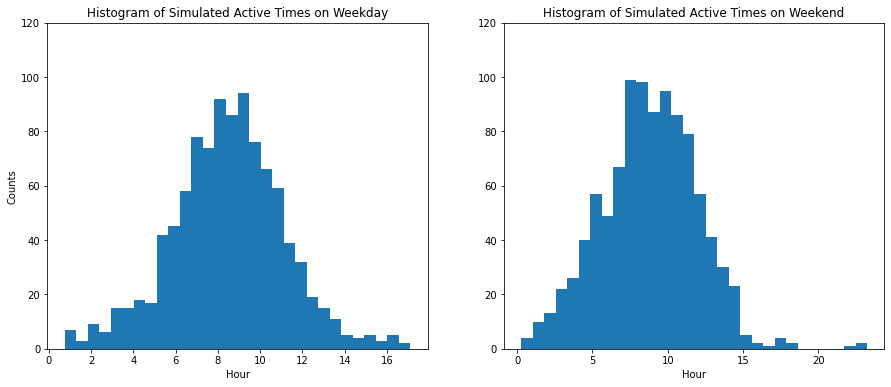

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].hist(simlated_working_time.loc[simlated_working_time['weekday'] == 1]['active_time'], bins=30)
ax[0].set_title('Histogram of Simulated Active Times on Weekday');
ax[0].set_xlabel('Hour');
ax[0].set_ylabel('Counts');
ax[0].set_ylim(0,120)
ax[1].hist(simlated_working_time.loc[simlated_working_time['weekday'] == 0]['active_time'], bins=30)
ax[1].set_title('Histogram of Simulated Active Times on Weekend');
ax[1].set_xlabel('Hour');
ax[1].set_ylim(0,120)
plt.savefig('../fig/simulated_active_times.png')

In [21]:
## Stat of online time
print(simlated_working_time.groupby(['weekday', 'shift'])['active_time'].mean())
print(simlated_working_time.groupby(['weekday', 'shift'])['active_time'].std())

weekday  shift
0        A        8.039783
         B        9.514105
1        A        8.754354
         B        8.199269
Name: active_time, dtype: float64
weekday  shift
0        A        3.367830
         B        2.822941
1        A        2.481417
         B        2.785278
Name: active_time, dtype: float64


### Statistics summary of the simulation

In [22]:
simlated_working_time.head()

,weekday,start_time,end_time,shift,active_time
0,1,2020-01-01 07:20:00,2020-01-01 16:13:00,A,8.883333
1,0,2020-01-01 17:25:35,2020-01-02 02:38:19,B,9.212222
2,1,2020-01-01 17:12:00,2020-01-01 22:31:00,B,5.316667
3,0,2020-01-01 17:37:18,2020-01-02 04:27:00,B,10.828333
4,1,2020-01-01 05:00:02,2020-01-01 13:58:11,A,8.969167


In [23]:
### Manually + hard code the calculation of wrapping hours over a day

simlated_working_time['start_time_minute'] = [time.hour*60 + time.minute for time in simlated_working_time['start_time'].apply(lambda x: x.time())]
simlated_working_time['end_time_minute'] = [time.hour*60 + time.minute for time in simlated_working_time['end_time'].apply(lambda x: x.time())]

simlated_working_time['start_time_minute_rep'] = simlated_working_time['start_time_minute']
simlated_working_time['end_time_minute_rep'] = simlated_working_time['end_time_minute']

## handle hours before the midnight of Shift A PU on weekday
simlated_working_time.loc[(simlated_working_time['shift'] == 'A') &
                         (simlated_working_time['weekday'] == 1), 'start_time_minute_rep'] = [t-(24*60) if t>(23*60+30) else t \
                                                                                              for t in simlated_working_time.loc[(simlated_working_time['shift'] == 'A') &
                                                                                                                                 (simlated_working_time['weekday'] == 1),
                                                                                                                                 'start_time_minute_rep']]
## handle hours before the midnight of Shift A PU on weekday
simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                         (simlated_working_time['weekday'] == 1), 'end_time_minute_rep'] = [t-(24*60) if t>(20*60+30) else t \
                                                                                              for t in simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                                                                                                                                 (simlated_working_time['weekday'] == 1),
                                                                                                                                 'end_time_minute_rep']]
                                                                                                                                 
 
                                                                                                                                 
## handle hours before the midnight of Shift A PU on weekday
simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                         (simlated_working_time['weekday'] == 0), 'start_time_minute_rep'] = [t+(24*60) if t<=(2*60) else t \
                                                                                              for t in simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                                                                                                                                 (simlated_working_time['weekday'] == 0), 
                                                                                                                                 'start_time_minute_rep']]

simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                         (simlated_working_time['weekday'] == 0), 'end_time_minute_rep'] = [t-(24*60) if t>(22*60) else t \
                                                                                              for t in simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                                                                                                                                 (simlated_working_time['weekday'] == 0), 
                                                                                                                                 'end_time_minute_rep']]

In [24]:
simlated_working_time.head()

,weekday,start_time,end_time,shift,active_time,start_time_minute,end_time_minute,start_time_minute_rep,end_time_minute_rep
0,1,2020-01-01 07:20:00,2020-01-01 16:13:00,A,8.883333,440,973,440,973
1,0,2020-01-01 17:25:35,2020-01-02 02:38:19,B,9.212222,1045,158,1045,158
2,1,2020-01-01 17:12:00,2020-01-01 22:31:00,B,5.316667,1032,1351,1032,-89
3,0,2020-01-01 17:37:18,2020-01-02 04:27:00,B,10.828333,1057,267,1057,267
4,1,2020-01-01 05:00:02,2020-01-01 13:58:11,A,8.969167,300,838,300,838


In [25]:
mean_stat = simlated_working_time.groupby(['weekday', 'shift'])['start_time_minute', 'end_time_minute']\
                    .agg(lambda x: "{}:{}".format(int(x.mean()//60), int(x.mean()%60)))
mean_stat

/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


start_time_minute end_time_minute
weekday shift                                  
0       A                  8:33           16:36
        B                 17:31             5:8
1       A                   7:2           15:41
        B                 17:14            6:24

In [26]:
std_stat = simlated_working_time.groupby(['weekday', 'shift'])['start_time_minute', 'end_time_minute']\
                    .agg(lambda x: "{}:{}".format(int(x.std()//60), int(x.std()%60)))
std_stat

/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


start_time_minute end_time_minute
weekday shift                                  
0       A                  2:32            2:21
        B                  2:45            5:21
1       A                  1:50            1:52
        B                  1:46            8:21

In [28]:
sim_merged_stat = mean_stat.merge(std_stat, on = ['weekday', 'shift'])#.to_latex()
sim_merged_stat
sim_merged_stat = sim_merged_stat[['start_time_minute_x', 'end_time_minute_x', 
                                   'start_time_minute_y', 'end_time_minute_y']]
sim_merged_stat.rename(columns = {'start_time_minute_x': 'Mean Start Time',
                              'start_time_minute_y': 'STD Start Time',
                              'end_time_minute_x': 'Mean End Time',
                              'end_time_minute_y': 'STD End Time'}, inplace=True)
print(sim_merged_stat)
print(sim_merged_stat.to_latex())

              Mean Start Time Mean End Time STD Start Time STD End Time
weekday shift                                                          
0       A                8:33         16:36           2:32         2:21
        B               17:31           5:8           2:45         5:21
1       A                 7:2         15:41           1:50         1:52
        B               17:14          6:24           1:46         8:21
\begin{tabular}{llllll}
\toprule
  &   & Mean Start Time & Mean End Time & STD Start Time & STD End Time \\
weekday & shift &                 &               &                &              \\
\midrule
0 & A &            8:33 &         16:36 &           2:32 &         2:21 \\
  & B &           17:31 &           5:8 &           2:45 &         5:21 \\
1 & A &             7:2 &         15:41 &           1:50 &         1:52 \\
  & B &           17:14 &          6:24 &           1:46 &         8:21 \\
\bottomrule
\end{tabular}



----

### Income per shift

In [3]:
path = '../data/'
sampled_trip = pd.read_csv(path + 'trip_cleaned.csv')
sampled_trip.head()

In [68]:
k = 5
# sampled_trip['shift_id'] = (sampled_trip['delta'] > k).cumsum()
sampled_trip['shift_id'] = sampled_trip['delta'] > k
sampled_trip['shift_id']  = sampled_trip.groupby(['hack_license'])[['shift_id']].cumsum()
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,delta,last_dropoff,first_pickup,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday,shift_id
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,0.183333,0,0.0,19:00:00,19:00:00,2013-06-24,2013-06-24,1,1,0.0
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,0.250000,0,0.0,19:30:00,19:15:00,2013-06-24,2013-06-24,1,1,0.0
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,0.116667,0,0.0,20:15:00,19:45:00,2013-06-24,2013-06-24,1,1,0.0
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,0.033333,0,0.0,20:30:00,20:15:00,2013-06-24,2013-06-24,1,1,0.0
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,0.033333,0,0.0,20:30:00,20:30:00,2013-06-24,2013-06-24,1,1,0.0


In [71]:
shifts_income = sampled_trip.groupby(['shift_id','hack_license']).agg({'total_amount':np.sum,
                                                                       'pickup_datetime':np.min,
                                                                       'dropoff_datetime':np.max}).reset_index()[['shift_id',
                                                                                                                  'hack_license',
                                                                                                                  'total_amount',
                                                                                                                  'pickup_datetime',
                                                                                                                  'dropoff_datetime']]
shifts_income['pickup_weekday'] = (shifts_income.loc[:,'pickup_datetime'].dt.dayofweek // 5 == 0).astype(int)
shifts_income['dropoff_weekday'] = (shifts_income.loc[:,'dropoff_datetime'].dt.dayofweek // 5 == 0).astype(int)

shifts_income.head()

,shift_id,hack_license,total_amount,pickup_datetime,dropoff_datetime,pickup_weekday,dropoff_weekday
0,0.0,2013000001,91.60,2013-06-24 18:55:00,2013-06-24 21:03:00,1,1
1,0.0,2013000002,164.43,2013-06-01 00:00:48,2013-06-01 04:33:06,0,0
2,0.0,2013000003,182.87,2013-06-01 00:03:00,2013-06-01 04:58:00,0,0
3,0.0,2013000004,48.50,2013-06-01 00:06:00,2013-06-01 01:04:00,0,0
4,0.0,2013000005,471.14,2013-06-01 15:05:00,2013-06-02 03:21:00,0,0


In [24]:
def get_shift(time, weekday=True, pickup=True):
    if weekday:
        if pickup:
            if (time > datetime.time(23, 30)) | (time <= datetime.time(11, 30)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(8, 30)) & (time <= datetime.time(20, 30)):
                return 'A'
            else:
                return 'B'            
    else: ## weekend
        if pickup:
            if (time > datetime.time(2, 0)) & (time <= datetime.time(14, 0)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(10, 0)) & (time <= datetime.time(22, 0)):
                return 'A'
            else:
                return 'B'        
        return None

In [73]:
shifts_income.loc[:,'PU_time'] = shifts_income['pickup_datetime'].apply(lambda x: x.time())
shifts_income.loc[:,'DO_time'] = shifts_income['dropoff_datetime'].apply(lambda x: x.time())
shifts_income.loc[(shifts_income['pickup_weekday']==1), '_PU_shift'] = shifts_income.PU_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=True))
shifts_income.loc[(shifts_income['dropoff_weekday']==1), '_DO_shift'] = shifts_income.DO_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=False))

## determine shift for weekends
shifts_income.loc[(shifts_income['pickup_weekday']==0) , '_PU_shift'] = shifts_income.PU_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=True))
shifts_income.loc[(shifts_income['dropoff_weekday']==0), '_DO_shift'] = shifts_income.DO_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=False))
shifts_income.head()

,shift_id,hack_license,total_amount,pickup_datetime,dropoff_datetime,pickup_weekday,dropoff_weekday,PU_time,DO_time,_PU_shift,_DO_shift
0,0.0,2013000001,91.60,2013-06-24 18:55:00,2013-06-24 21:03:00,1,1,18:55:00,21:03:00,B,B
1,0.0,2013000002,164.43,2013-06-01 00:00:48,2013-06-01 04:33:06,0,0,00:00:48,04:33:06,B,B
2,0.0,2013000003,182.87,2013-06-01 00:03:00,2013-06-01 04:58:00,0,0,00:03:00,04:58:00,B,B
3,0.0,2013000004,48.50,2013-06-01 00:06:00,2013-06-01 01:04:00,0,0,00:06:00,01:04:00,B,B
4,0.0,2013000005,471.14,2013-06-01 15:05:00,2013-06-02 03:21:00,0,0,15:05:00,03:21:00,B,B


In [88]:
# sampled_trip.loc[(sampled_trip['pickup_day']=='2013-06-01') & (sampled_trip['hack_license']==2013000056),
#                  ['pickup_datetime','dropoff_datetime','trip_distance','total_amount']]

In [91]:
N = shifts_income.shape[0]
n0 = len(shifts_income.loc[(shifts_income['total_amount']>1000), 'total_amount'])
n1 = len(shifts_income.loc[(shifts_income['total_amount']<=100), 'total_amount'])
n2 = len(shifts_income.loc[(shifts_income['total_amount']<500), 'total_amount'])
print('{n0} ({n0_per:.2f}%) records: driver income per shift > $1000\n\
{n1} ({n1_per:.2f}%) records: driver income per shift < $100\n\
{n2} ({n2_per:.2f}%) records: driver income per shift < $500\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                                  n1 = n1, n1_per = n1/N*100,
                                                                  n2 = n2, n2_per = n2/N*100))
print(shifts_income['total_amount'].describe())

560 (0.08%) records: driver income per shift > $1000
28367 (4.26%) records: driver income per shift < $100
634975 (95.29%) records: driver income per shift < $500
count    666337.000000
mean        310.319288
std         122.562620
min           3.500000
25%         239.210000
50%         310.530000
75%         378.930000
max        7704.540000
Name: total_amount, dtype: float64


In [96]:
index_income = (shifts_income['total_amount']<=1000)

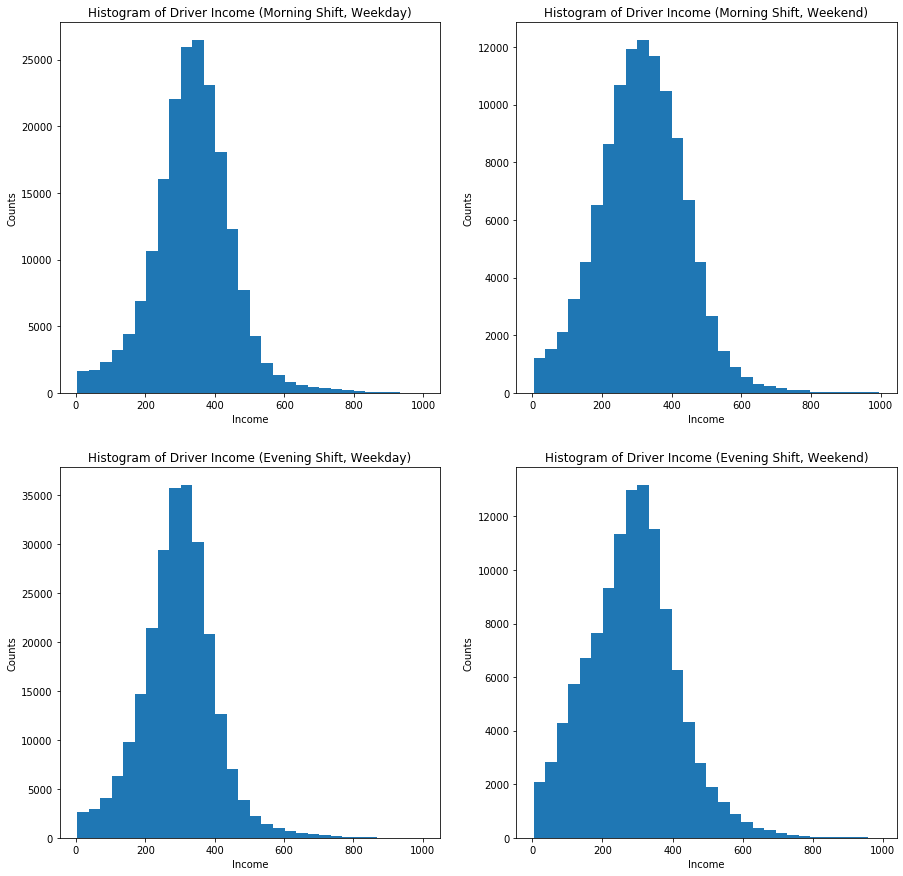

In [101]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

ax[0,0].hist(shifts_income.loc[index_income & 
                               (shifts_income['pickup_weekday'] == 1) & 
                               (shifts_income['_PU_shift'] == 'A')]['total_amount'], bins=30)
ax[0,0].set_title('Histogram of Driver Income (Morning Shift, Weekday)');
ax[0,0].set_xlabel('Income');
ax[0,0].set_ylabel('Counts');

ax[0,1].hist(shifts_income.loc[index_income & 
                               (shifts_income['pickup_weekday'] == 0) & 
                               (shifts_income['_PU_shift'] == 'A')]['total_amount'], bins=30)
ax[0,1].set_title('Histogram of Driver Income (Morning Shift, Weekend)');
ax[0,1].set_xlabel('Income');
ax[0,1].set_ylabel('Counts');

ax[1,0].hist(shifts_income.loc[index_income & 
                               (shifts_income['pickup_weekday'] == 1) & 
                               (shifts_income['_PU_shift'] == 'B')]['total_amount'], bins=30)
ax[1,0].set_title('Histogram of Driver Income (Evening Shift, Weekday)');
ax[1,0].set_xlabel('Income');
ax[1,0].set_ylabel('Counts');

ax[1,1].hist(shifts_income.loc[index_income & 
                               (shifts_income['pickup_weekday'] == 0) & 
                               (shifts_income['_PU_shift'] == 'B')]['total_amount'], bins=30)
ax[1,1].set_title('Histogram of Driver Income (Evening Shift, Weekend)');
ax[1,1].set_xlabel('Income');
ax[1,1].set_ylabel('Counts');

fig.savefig(path + '../img/driver_income.png');